# Logistic Regression 

In [1]:
DATA_DIR = 'data'

In [2]:
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.classification import LogisticRegression
import os

In [3]:
#creating spark session
spark = SparkSession.builder.appName('sentimentAnalysis').getOrCreate()

In [4]:
pre_processed_train_data = spark.read.parquet(os.path.join(DATA_DIR, 'train_n2_25000.parquet'))

In [92]:
pre_processed_train_data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- data_prep: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- count_vect: vector (nullable = true)
 |-- features: vector (nullable = true)



Let's test some parameters, so we can chose the ones we will use int the model afterwards

In [5]:
%%time 

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

rdc = LogisticRegression()

paramGrid = ParamGridBuilder().addGrid(rdc.maxIter, [5, 10, 15])\
                              .addGrid(rdc.regParam, [0.0001, 0.001, 0.0005])\
                              .addGrid(rdc.elasticNetParam, [0.2, 0.3, 0.4])\
                              .build()
evaluator = BinaryClassificationEvaluator()
valid = TrainValidationSplit(estimator = rdc,
                             estimatorParamMaps=paramGrid,
                             evaluator = evaluator,
                             trainRatio = 0.50)
model = valid.fit(pre_processed_train_data)
best_model = model.bestModel
result = best_model.transform(pre_processed_train_data)

CPU times: user 1.17 s, sys: 311 ms, total: 1.48 s
Wall time: 2min 39s


In [28]:
result.select('label', 'probability', 'prediction').toPandas().head()

,label,probability,prediction
0,0,"[0.7647649987264917, 0.2352350012735082]",0.0
1,0,"[0.4693901481183246, 0.5306098518816754]",1.0
2,0,"[0.5981790542862395, 0.40182094571376054]",0.0
3,0,"[0.44151971508332244, 0.5584802849166776]",1.0
4,0,"[0.44151971508332244, 0.5584802849166776]",1.0


In [135]:
def evaluate(result):
    predictionAndLabels = result
    metrics = ["areaUnderROC","areaUnderPR"]
    for m in metrics:
        evaluator = BinaryClassificationEvaluator(metricName=m)
        print(str(m) + ": " + str(evaluator.evaluate(predictionAndLabels)))

In [136]:
evaluate(result)

areaUnderROC: 0.6756835964976943
areaUnderPR: 0.7350748803870176


In [9]:
best_model.extractParamMap()

{Param(parent='LogisticRegression_06847243edb2', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_06847243edb2', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.3,
 Param(parent='LogisticRegression_06847243edb2', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_06847243edb2', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_06847243edb2', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_06847243edb2', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_06847243edb2', name='maxIter', doc='maximum number of iterations (>= 0)'): 

In [57]:
model.extractParamMap()

{Param(parent='TrainValidationSplitModel_72e0bb3e2657', name='seed', doc='random seed.'): 1215852686270291499,
 Param(parent='TrainValidationSplitModel_72e0bb3e2657', name='estimator', doc='estimator to be cross-validated'): LogisticRegression_34e71a7cd7bf,
 Param(parent='TrainValidationSplitModel_72e0bb3e2657', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='LogisticRegression_34e71a7cd7bf', name='maxIter', doc='max number of iterations (>= 0).'): 5,
   Param(parent='LogisticRegression_34e71a7cd7bf', name='regParam', doc='regularization parameter (>= 0).'): 0.0001,
   Param(parent='LogisticRegression_34e71a7cd7bf', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2},
  {Param(parent='LogisticRegression_34e71a7cd7bf', name='maxIter', doc='max number of iterations (>= 0).'): 5,
   Param(parent='LogisticRegression_34e71a7cd7bf', name='regParam', doc=

In [59]:
#!pip install emoji --upgrade
import emoji
print(emoji.emojize(' :trophy: The winner parameters are: maxIter = 10 regParam = 0.001 elasticNetParam = 0.3 !!!! :trophy: '))

 🏆 The winner parameters are: maxIter = 10 regParam = 0.001 elasticNetParam = 0.3 !!!! 🏆 


In [6]:
pre_processed_test_data = spark.read.parquet(os.path.join(DATA_DIR, 'test_n2_25000.parquet'))

In [7]:
def logistic_regression_classifier(training_df, testing_df):
    """
    Apply Logistic Regression Classifier to test data for predicting sentiment of Tweets.
    :param training_df: Trained labelled data
    :param testing_df: Test data
    :return: transformed dataframe of predicted labels for tweets
    """
    lor = LogisticRegression(regParam = 0.001, maxIter = 10, elasticNetParam = 0.3)
    model = lor.fit(training_df)
    return model.transform(testing_df), model.summary

In [9]:
%%time
result_lr, summary = logistic_regression_classifier(pre_processed_train_data, pre_processed_test_data)

CPU times: user 33.8 ms, sys: 7.96 ms, total: 41.7 ms
Wall time: 5.23 s


# Metrics

let's get some probabilities

In [11]:
from pyspark.sql.functions import udf, when, col
from pyspark.sql.types import FloatType

prob_neg = udf(lambda v:float(v[0]),FloatType())
prob_pos = udf(lambda v:float(v[1]),FloatType())

probability_column = when(col('label') == 1, prob_pos('probability'))\
    .when(col('label') == 0, prob_neg('probability'))

result_prob = result_lr.withColumn('probability', probability_column)

In [12]:
result_prob.count()

479872

In [ ]:
import pandas as pd

def confusion_matrix(result_df):
    """
    Generate Confusion Matrix for showing the performance of algorithm.
    :param result_df: Dataframe returned from the model
    :return: pandas dataframe
    """
    true_positives = result_df.filter((result_df.label == 1.0) & (result_df.prediction == 1.0)).count()
    true_negatives = result_df.filter((result_df.label == 0.0) & (result_df.prediction == 0.0)).count()
    false_positives = result_df.filter((result_df.label == 0.0) & (result_df.prediction == 1.0)).count()
    false_negatives = result_df.filter((result_df.label == 1.0) & (result_df.prediction == 0.0)).count()

    matrix = {"Positive": pd.Series([true_positives, false_positives], index=["Positive", "Negative"]),
              "Negative": pd.Series([false_negatives, true_negatives], index=["Positive", "Negative"])}

    df = pd.DataFrame(matrix)
    df.columns.name = "Actual / Predicted"
    return df

In [13]:
confusion_matrix(result_lr)

Actual / Predicted,Positive,Negative
Positive,203379,36772
Negative,101015,138706


In [14]:
confusion_matrix(result_prob.where(col('probability') > 0.50))

Actual / Predicted,Positive,Negative
Positive,203379,0
Negative,0,138706


In [15]:
result_prob.where(col('probability') < 0.51).select('text', 'prediction', 'label', 'probability').toPandas().head(200)

,text,prediction,label,probability
0,just practising.....how I feel ...,1.0,0,0.437099
1,or i just worry too much?,1.0,0,0.437099
2,"Orlando Lost The Series. Oh Well, Mayb...",1.0,0,0.475250
3,rinitis sucks!!!!!,1.0,0,0.437099
4,UGHHHHHHHHHHHHHHHHHHHHHHHHHHHHH,1.0,0,0.437099
5,"fuck, fuck, fuuuuck!",1.0,0,0.467466
6,"SOX! Floyd was great, but relievers nee...",1.0,0,0.325152
7,eh must leave New Mexico and soon!,1.0,0,0.493817
8,"please, can anyone give loads of money or v...",1.0,0,0.437099
9,-- Meet your Meat http://bit.ly/15SSCI,1.0,0,0.437099


In [116]:
result_prob.where(col('probability') > 0.51).select('text', 'prediction', 'label', 'probability').toPandas().head(200)

,text,prediction,label,probability
0,My cell phone screen is dead. Soooooooooo...,0.0,0,0.652139
1,NO MORE SICKNESS. strike i say STRIKE! ohh...,0.0,0,0.600999
2,everyone went home. and not everyone was e...,0.0,0,0.757374
3,geez I'm feeling their pain,0.0,0,0.817140
4,... have to go now ??? 13 more minutes .....,0.0,0,0.586964
5,Feeeling like shit right now. I really want...,0.0,0,0.979364
6,I didn't realize it was THAT deep. Geez giv...,0.0,0,0.593721
7,I'm SICK of bedtime battles,0.0,0,0.884411
8,Really Dont Like Doing my Room Its So Borin...,0.0,0,0.777511
9,This magazine story just broke my heart at ...,0.0,0,0.948792


In [16]:
def calculate_accuracy(result_df):
    """
    Calculate accuracy of model against actual data.
    :param result_df: Dataframe returned from the model
    :return: accuracy between 0 and 1
    """
    return 1.0 * result_df.filter(result_df.label == result_df.prediction).count() / result_df.count()

In [17]:
calculate_accuracy(result_lr)

0.7128671812483329

In [18]:
import matplotlib.pyplot as plt

roc = summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(summary.areaUnderROC))

<Figure size 640x480 with 1 Axes>

Training set areaUnderROC: 0.8069099742103283


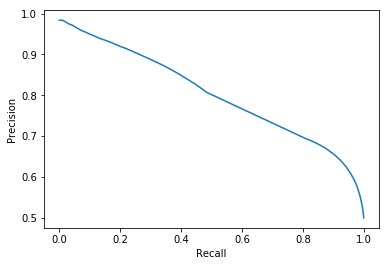

In [19]:
pr = summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

**1. Model optimization**
* If we imagine that we are designing this model for use in a company application, we know that the company does *not* want positive reviews to be categorized as negative. That is, we want to have as few **false positives** as possible. 
* On the other hand, if our manager <img src='notebook_ims/manager.jpg' width=8% /> asks for an application that will catch almost *all* cases of negative reviews, even if it means a higher number of false positives, then we'd want as few **false negatives** as possible.
* To train according to specific product demands and goals, we do not want to optimize for accuracy only. Instead, we want to optimize for a metric that can help us decrease the number of false positives or negatives. 

<img src='notebook_ims/precision_recall.png' width=40% />
     

**2. Imbalanced training data**
* At the start of this notebook, we saw that about 10 % of the data was labeled as false negatives. So, even if a model labels **all** of our data as valid, it will still have a poor accuracy. 
* This may result in some overfitting towards valid data, which accounts for some **false negatives**; cases in which negative reviews (0) are incorrectly characterized as positive (1).

So, let's address these issues in order; first, tuning our model and optimizing for a specific metric during training, and second, accounting for class imbalance in the training set. 

**Scenario:**
* A company has asked you to build a model that detects cases of positive reviews with an accuracy of about 85%. 

In this case, we want to build a model that has as many true positives and as few false negatives, as possible. This corresponds to a model with a high **recall**: true positives / (true positives + false negatives). 

HOW TO DO IT USING SPARK?

I will assume that performance on a training set will be within about 5% of the performance on a test set. So, for a recall of about 85%, I'll aim for a bit higher, 90%.